In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from pypfopt import BlackLittermanModel, risk_models, expected_returns
from pypfopt import EfficientFrontier, objective_functions
import warnings
warnings.filterwarnings('ignore')

In [4]:
np.random.seed(42)

In [5]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [54]:
dow30_tickers = [
    'AAPL', 'MSFT', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS',
     'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD',
    'MMM', 'MRK', 'NKE', 'PG', 'TRV', 'UNH',  'VZ', 'WBA', 'WMT', 'NVDA'
]

In [55]:
print("Fetching historical data for Dow Jones 30...")
start_date = '2006-01-01'
end_date = '2024-01-01'

Fetching historical data for Dow Jones 30...


In [56]:
prices = yf.download(dow30_tickers, start=start_date, end=end_date)["Close"]
prices = prices.dropna()

[*********************100%***********************]  29 of 29 completed


In [57]:
prices

Ticker,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,NVDA,PG,TRV,UNH,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,2.246550,55.568771,39.139183,50.119682,35.203148,8.485644,11.488687,28.028049,19.693220,94.820465,...,15.721172,18.780910,8.359502,0.292044,34.022335,28.941027,48.620506,10.203048,26.447031,10.321805
2006-01-04,2.253163,55.305984,38.758690,50.639099,36.098461,8.914389,11.752035,27.947403,19.362305,93.510788,...,15.903592,18.871876,8.320600,0.300221,34.085995,29.261971,48.738655,10.501949,25.625469,10.341900
2006-01-05,2.235431,54.503853,39.169037,50.041428,36.098461,8.936693,12.081223,27.605839,19.701288,93.473999,...,15.927592,18.885870,8.371172,0.307021,33.976021,29.545156,48.589005,10.622850,25.392426,10.201236
2006-01-06,2.293135,54.005978,39.303341,49.344131,36.817131,9.875960,12.357742,28.108707,19.967634,94.798424,...,15.898791,18.829893,8.344913,0.312064,33.941288,29.708773,49.542030,10.665384,25.270060,10.243660
2006-01-09,2.285620,54.614498,40.280689,48.931454,37.487087,9.548828,12.548668,27.966385,20.177479,95.938866,...,16.158007,18.794903,8.461626,0.320775,34.195969,29.721340,48.360592,10.709608,25.584698,10.205704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,192.192551,271.218292,182.338852,260.440002,283.368195,264.026459,47.863064,141.499268,89.819290,367.979187,...,102.910141,370.375763,104.985367,48.808281,140.019135,180.990509,506.513458,33.989986,24.237406,51.332783
2023-12-26,191.646545,270.970123,182.722061,262.790009,288.511383,263.907471,48.044617,142.773285,89.750214,368.907288,...,102.843254,370.454865,104.965927,49.257076,140.655273,182.247116,506.240936,33.980911,24.597919,51.254135
2023-12-27,191.745834,273.480377,183.802917,262.100006,290.941376,264.403137,48.197498,142.304901,89.187729,371.681763,...,103.177689,369.871552,104.101082,49.395020,140.770874,183.737503,508.927734,33.826790,24.625648,51.735844


In [58]:
market_caps = {}
for ticker in dow30_tickers:
    
    info = yf.Ticker(ticker).info
    market_caps[ticker] = info.get('marketCap', 100e9)  # Default to 100B if not available
    

print(f"Data fetched successfully. Shape: {prices.shape}")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")

Data fetched successfully. Shape: (4529, 29)
Date range: 2006-01-03 00:00:00 to 2023-12-29 00:00:00


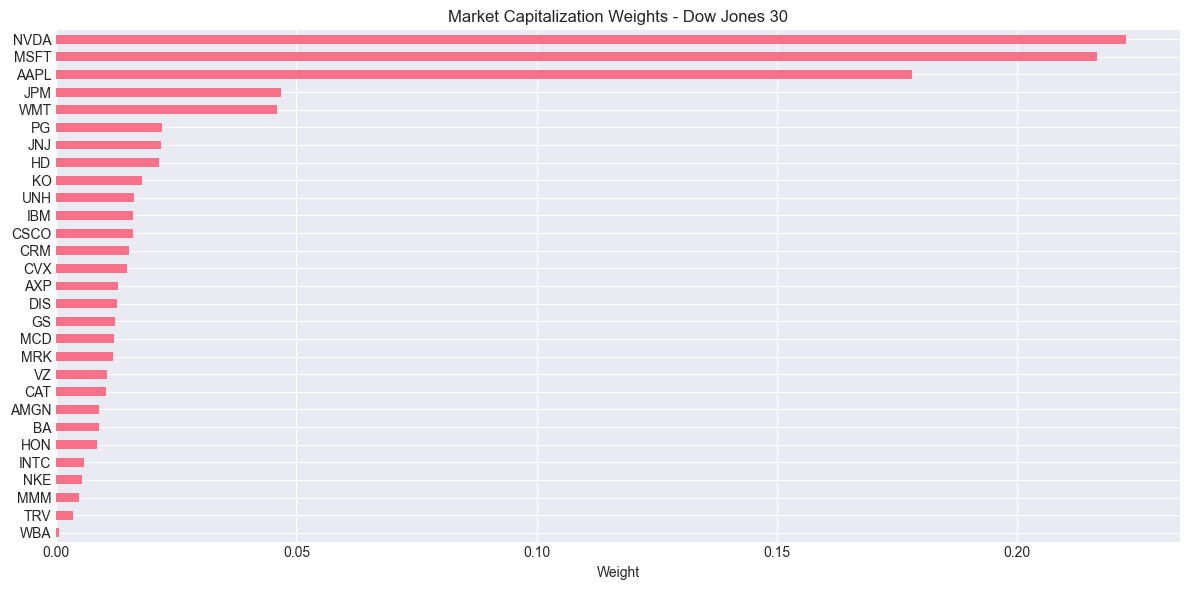

In [59]:
total_mcap = sum(market_caps.values())
market_weights = {ticker: mcap/total_mcap for ticker, mcap in market_caps.items()}
market_weights_series = pd.Series(market_weights)
# Visualize market weights
plt.figure(figsize=(12, 6))
market_weights_series.sort_values(ascending=True).plot(kind='barh')
plt.title('Market Capitalization Weights - Dow Jones 30')
plt.xlabel('Weight')
plt.tight_layout()
plt.show()

In [60]:
print("\nTop 10 stocks by market cap weight:")
print(market_weights_series.sort_values(ascending=False).head(10))


Top 10 stocks by market cap weight:
NVDA    0.222849
MSFT    0.216665
AAPL    0.178271
JPM     0.046748
WMT     0.045963
PG      0.022071
JNJ     0.021697
HD      0.021320
KO      0.017748
UNH     0.016224
dtype: float64


In [153]:
def generate_enhanced_bl_views(confidence=0.75):
    """
    Generate more sophisticated views including relative views
    
    Returns:
    - P: Pick matrix for views
    - Q: View vector (expected returns)
    - confidences: View confidences
    - view_descriptions: Text descriptions of views
    """
    views = []
    view_descriptions = []
    
    # 1. Absolute views (your existing ones)
    views.append({
        'type': 'absolute',
        'asset': 'AAPL',
        'return': 0.15,
        'confidence': confidence,
        'description': 'AAPL: 15% annual return (continued innovation)'
    })
    
    views.append({
        'type': 'absolute',
        'asset': 'MSFT',
        'return': 0.12,
        'confidence': confidence,
        'description': 'MSFT: 12% annual return (cloud growth)'
    })
    
    # 2. Additional absolute views based on sector trends
    views.append({
        'type': 'absolute',
        'asset': 'CVX',
        'return': 0.08,
        'confidence': confidence,
        'description': 'CVX: 8% annual return (energy sector stability)'
    })
    
    views.append({
        'type': 'absolute',
        'asset': 'JPM',
        'return': 0.10,
        'confidence': confidence,
        'description': 'JPM: 10% annual return (rising interest rates benefit)'
    })
    
    # 3. Relative views
    views.append({
        'type': 'relative',
        'asset_long': 'NVDA',
        'asset_short': 'INTC',
        'spread': 0.10,  # NVDA will outperform INTC by 10%
        'confidence': confidence,
        'description': 'NVDA outperforms INTC by 10%'
    })
    
    views.append({
        'type': 'relative',
        'asset_long': 'VZ',  # Changed from VZ to V (Visa)
        'asset_short': 'AXP',
        'spread': 0.05,  # V will outperform AXP by 5%
        'confidence': confidence,
        'description': 'VZ outperforms AXP by 5%'
    })
    
    # Now construct P matrix and Q vector
    n_views = len(views)
    n_assets = len(prices.columns)
    asset_list = prices.columns.tolist()
    
    #print(f"Generating {n_views} views for {n_assets} assets...")
    
    P = np.zeros((n_views, n_assets))
    Q = np.zeros(n_views)
    confidences = np.zeros(n_views)
    
    view_idx = 0
    for i, view in enumerate(views):
        if view['type'] == 'absolute':
            # Absolute view: asset will have specific return
            if view['asset'] in asset_list:
                asset_idx = asset_list.index(view['asset'])
                P[view_idx, asset_idx] = 1
                Q[view_idx] = view['return']
                confidences[view_idx] = view['confidence']
                view_descriptions.append(view['description'])
                view_idx += 1
            else:
                print(f"Warning: Asset {view['asset']} not in universe, skipping view")
                
        elif view['type'] == 'relative':
            # Relative view: asset_long - asset_short = spread
            if view['asset_long'] in asset_list and view['asset_short'] in asset_list:
                long_idx = asset_list.index(view['asset_long'])
                short_idx = asset_list.index(view['asset_short'])
                P[view_idx, long_idx] = 1
                P[view_idx, short_idx] = -1
                Q[view_idx] = view['spread']
                confidences[view_idx] = view['confidence']
                view_descriptions.append(view['description'])
                view_idx += 1
            else:
                missing = []
                if view['asset_long'] not in asset_list:
                    missing.append(view['asset_long'])
                if view['asset_short'] not in asset_list:
                    missing.append(view['asset_short'])
                print(f"Warning: Assets {missing} not in universe, skipping relative view")
    
    P = P[:view_idx]
    Q = Q[:view_idx]
    confidences = confidences[:view_idx]
    
    return P, Q, confidences, view_descriptions


In [103]:
# Test the enhanced views
print("\nEnhanced Black-Litterman Views:")
print("="*60)
P_test, Q_test, conf_test, desc_test = generate_enhanced_bl_views()

print(f"\nSuccessfully generated {len(desc_test)} views:")
for i, desc in enumerate(desc_test):
    print(f"View {i+1}: {desc}")
    print(f"   Expected return/spread: {Q_test[i]:.1%}")

# Analyze view types
absolute_views = np.sum(np.abs(P_test.sum(axis=1)) == 1)
relative_views = np.sum(np.abs(P_test.sum(axis=1)) < 0.01)
print(f"\nView breakdown: {absolute_views} absolute, {relative_views} relative")

# Show P matrix structure for relative views
print("\nP matrix for relative views (showing non-zero entries only):")
for i in range(len(P_test)):
    if np.abs(P_test[i].sum()) < 0.01:  # This is a relative view
        non_zero = np.where(P_test[i] != 0)[0]
        assets = [prices.columns[idx] for idx in non_zero]
        weights = [P_test[i, idx] for idx in non_zero]
        print(f"View {i+1}: {assets[0]} ({weights[0]:+.0f}) vs {assets[1]} ({weights[1]:+.0f})")


Enhanced Black-Litterman Views:

Successfully generated 6 views:
View 1: AAPL: 15% annual return (continued innovation)
   Expected return/spread: 15.0%
View 2: MSFT: 12% annual return (cloud growth)
   Expected return/spread: 12.0%
View 3: CVX: 8% annual return (energy sector stability)
   Expected return/spread: 8.0%
View 4: JPM: 10% annual return (rising interest rates benefit)
   Expected return/spread: 10.0%
View 5: NVDA outperforms INTC by 20% (AI chip dominance)
   Expected return/spread: 20.0%
View 6: VZ outperforms AXP by 5%
   Expected return/spread: 5.0%

View breakdown: 4 absolute, 2 relative

P matrix for relative views (showing non-zero entries only):
View 5: INTC (-1) vs NVDA (+1)
View 6: AXP (-1) vs VZ (+1)


In [130]:
def construct_bl_portfolio(prices, market_caps, P, Q, confidences, tau=0.025):
    """
    Construct Black-Litterman optimized portfolio
    
    Parameters:
    - prices: DataFrame of prices
    - market_caps: Dictionary of market capitalizations
    - views_dict: Dictionary of views
    - confidences: Dictionary of view confidences
    - tau: Black-Litterman tau parameter
    
    Returns:
    - bl_weights: Dictionary of optimized weights
    """
    # Use exponentially-weighted covariance for more recent emphasis
    S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
    
    # Initialize Black-Litterman model
    bl = BlackLittermanModel(cov_matrix = S, P=P, Q=Q, pi="market", market_caps=market_caps, 
                            risk_aversion=2.5, tau=tau, omega='idzorek', view_confidences=confidences)
    
    # Get posterior estimates
    bl_returns = bl.bl_returns()
    bl_cov = bl.bl_cov()
    
    # Optimize portfolio
    ef = EfficientFrontier(bl_returns, bl_cov)
    #ef.add_constraint(lambda w: w >= 0)  # Long-only constraint
    ef.add_constraint(lambda w: w <= 0.45)  # Max 45% per position
    
    # Maximize Sharpe ratio
    ef.max_sharpe(risk_free_rate=0.04)
    
    # Get clean weights
    bl_weights = ef.clean_weights()
    
    return bl_weights

In [95]:
class PortfolioBacktest:
    """
    Comprehensive backtesting engine for portfolio strategies
    """
    
    def __init__(self, prices, initial_value=1000000, rebalance_freq='Q', 
                 transaction_cost=0.001):
        """
        Initialize backtesting engine
        
        Parameters:
        - prices: DataFrame of adjusted close prices
        - initial_value: Initial portfolio value
        - rebalance_freq: Rebalancing frequency ('M' for monthly, 'Q' for quarterly)
        - transaction_cost: Transaction cost as percentage of trade value
        """
        self.prices = prices
        self.returns = prices.pct_change().dropna()
        self.initial_value = initial_value
        self.rebalance_freq = rebalance_freq
        self.transaction_cost = transaction_cost
        
        # Results storage
        self.portfolio_values = {}
        self.weights_history = {}
        self.turnover_history = {}
        
    def run_backtest(self, strategy_name, weight_function, lookback_window=252, bl_confidence=0.75):
        """
        Run backtest for a given strategy
        
        Parameters:
        - strategy_name: Name of the strategy
        - weight_function: Function that returns weights given historical data
        - lookback_window: Number of days for historical window
        """
        # Initialize results
        portfolio_values = [self.initial_value]
        weights_history = []
        turnover_history = []
        dates = []
        
        # Get rebalancing dates
        rebalance_dates = pd.date_range(
            start=self.prices.index[lookback_window],
            end=self.prices.index[-1],
            freq=self.rebalance_freq
        )
        
        # Initial weights (equal weight to start)
        current_weights = pd.Series(1/len(self.prices.columns), 
                                   index=self.prices.columns)
        
        # Track portfolio composition
        holdings = current_weights * self.initial_value / self.prices.iloc[lookback_window]
        
        print(f"\nRunning backtest for {strategy_name}...")
        print(f"Rebalancing frequency: {self.rebalance_freq}")
        print(f"Number of rebalancing dates: {len(rebalance_dates)}")
        
        # Simulate through time
        for i in range(lookback_window + 1, len(self.prices)):
            current_date = self.prices.index[i]
            
            # Check if rebalancing date
            if current_date in rebalance_dates:
                # Get historical data
                hist_prices = self.prices.iloc[:i]
                
                # Calculate new weights
                new_weights = weight_function(hist_prices, bl_confidence)
                new_weights = pd.Series(new_weights)
                
                # Calculate turnover
                turnover = np.abs(new_weights - current_weights).sum()
                turnover_history.append(turnover)
                
                # Calculate current portfolio value
                current_value = (holdings * self.prices.iloc[i]).sum()
                
                # Apply transaction costs
                transaction_costs = current_value * self.transaction_cost * turnover
                current_value -= transaction_costs
                
                # Rebalance holdings
                holdings = new_weights * current_value / self.prices.iloc[i]
                current_weights = new_weights
                weights_history.append(new_weights.to_dict())
                
            # Calculate daily portfolio value
            portfolio_value = (holdings * self.prices.iloc[i]).sum()
            portfolio_values.append(portfolio_value)
            dates.append(current_date)
        
        # Store results
        self.portfolio_values[strategy_name] = pd.Series(
            portfolio_values[1:], index=dates
        )
        self.weights_history[strategy_name] = weights_history
        self.turnover_history[strategy_name] = turnover_history
        
        print(f"Backtest complete for {strategy_name}")
        print(f"Final value: ${portfolio_values[-1]:,.2f}")
        print(f"Total return: {(portfolio_values[-1]/self.initial_value - 1)*100:.2f}%")
        
        return self.portfolio_values[strategy_name]

In [94]:
def market_cap_weights(hist_prices, confidence):
    """Calculate market-cap weighted portfolio"""
    # Use global market_caps (in practice, these would be time-varying)
    total_mcap = sum(market_caps.values())
    weights = {ticker: market_caps.get(ticker, 0)/total_mcap 
               for ticker in hist_prices.columns}
    return weights

def equal_weights(hist_prices, confidence):
    """Calculate equal-weighted portfolio"""
    n_assets = len(hist_prices.columns)
    weights = {ticker: 1/n_assets for ticker in hist_prices.columns}
    return weights

def black_litterman_weights(hist_prices, confidence):
    """Calculate Black-Litterman optimized weights"""
    # Generate views based on recent data
    recent_returns = hist_prices.pct_change().dropna()
    P, Q, confidences, _ = generate_enhanced_bl_views(confidence)
    
    bl_weights = construct_bl_portfolio(
        hist_prices, market_caps, P, Q, confidences
    )
    return bl_weights
   

In [154]:
backtest = PortfolioBacktest(
    prices,
    initial_value=1000000,
    rebalance_freq='Q',  # Quarterly rebalancing
    transaction_cost=0.01  # 1% transaction cost
)

# Store all results for plotting
all_results = {}

# First, run the benchmark strategies (they don't use confidence)
print("\nRunning benchmark strategies...")
backtest.run_backtest('Market-Cap Weighted', market_cap_weights)
all_results['Market-Cap Weighted'] = backtest.portfolio_values['Market-Cap Weighted']

backtest.run_backtest('Equal Weighted', equal_weights)
all_results['Equal Weighted'] = backtest.portfolio_values['Equal Weighted']

# Now run Black-Litterman with different confidence levels
confidences = [0.25, 0.5, 0.75, 1.0]  # Example confidence levels for views

for confidence in confidences:
    print(f"\nRunning Black-Litterman with confidence level: {confidence}")
    
    # Create a unique strategy name that includes confidence
    strategy_name = f'BL (Confidence {confidence:.0%})'
    
    # Create a wrapper function that uses the specific confidence
    def bl_weights_with_confidence(hist_prices, bl_confidence):
        return black_litterman_weights(hist_prices, bl_confidence)
    
    # Run backtest
    backtest.run_backtest(strategy_name, bl_weights_with_confidence, bl_confidence=confidence)
    
    # Store results
    all_results[strategy_name] = backtest.portfolio_values[strategy_name]


Running benchmark strategies...

Running backtest for Market-Cap Weighted...
Rebalancing frequency: Q
Number of rebalancing dates: 67
Backtest complete for Market-Cap Weighted
Final value: $26,826,299.49
Total return: 2582.63%

Running backtest for Equal Weighted...
Rebalancing frequency: Q
Number of rebalancing dates: 67
Backtest complete for Equal Weighted
Final value: $8,645,610.41
Total return: 764.56%

Running Black-Litterman with confidence level: 0.25

Running backtest for BL (Confidence 25%)...
Rebalancing frequency: Q
Number of rebalancing dates: 67
Backtest complete for BL (Confidence 25%)
Final value: $53,233,632.86
Total return: 5223.36%

Running Black-Litterman with confidence level: 0.5

Running backtest for BL (Confidence 50%)...
Rebalancing frequency: Q
Number of rebalancing dates: 67
Backtest complete for BL (Confidence 50%)
Final value: $59,455,993.23
Total return: 5845.60%

Running Black-Litterman with confidence level: 0.75

Running backtest for BL (Confidence 75%)

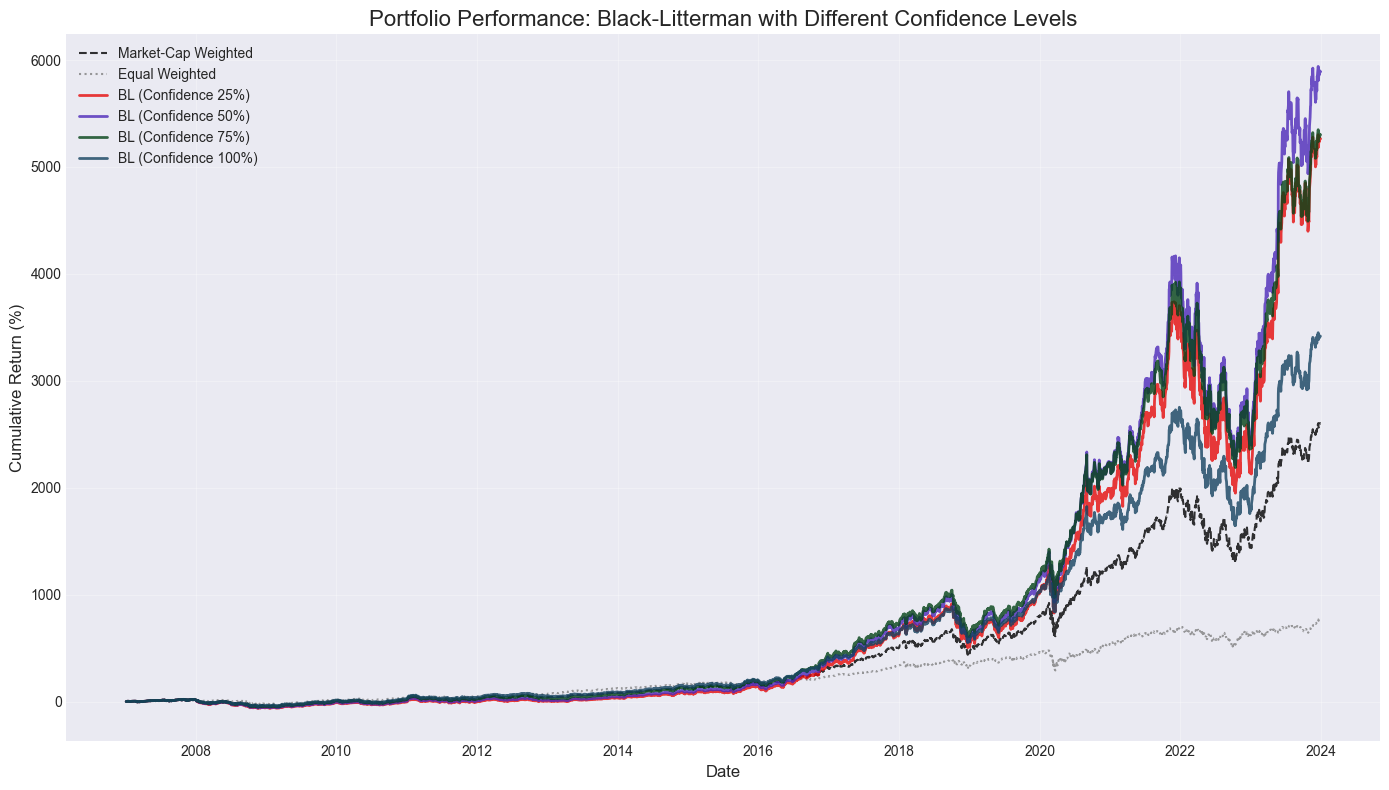

In [155]:
plt.figure(figsize=(14, 8))

# Define colors and styles
colors = {
    'Market-Cap Weighted': 'black',
    'Equal Weighted': 'gray',
    'BL (Confidence 25%)': "#e60b0b",  # Red
    'BL (Confidence 50%)': "#4d29b9",  # Purple 
    'BL (Confidence 75%)': "#044317",  # Dark green
    'BL (Confidence 100%)': '#154360'  # Dark blue
}

linestyles = {
    'Market-Cap Weighted': '--',
    'Equal Weighted': ':',
    'BL (Confidence 25%)': '-',
    'BL (Confidence 50%)': '-',
    'BL (Confidence 75%)': '-',
    'BL (Confidence 100%)': '-'
}

# Plot cumulative returns for each strategy
for strategy_name, portfolio_values in all_results.items():
    cumulative_returns = (portfolio_values / portfolio_values.iloc[0] - 1) * 100
    
    plt.plot(
        cumulative_returns.index,
        cumulative_returns.values,
        label=strategy_name,
        color=colors.get(strategy_name, 'blue'),
        linestyle=linestyles.get(strategy_name, '-'),
        linewidth=2 if 'BL' in strategy_name else 1.5,
        alpha=0.8
    )

plt.title('Portfolio Performance: Black-Litterman with Different Confidence Levels', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (%)', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [156]:
print("\nPerformance Summary by Strategy and Confidence Level:")
print("="*80)

summary_data = []
for strategy_name, portfolio_values in all_results.items():
    daily_returns = portfolio_values.pct_change().dropna()
    
    # Calculate metrics
    total_return = (portfolio_values.iloc[-1] / portfolio_values.iloc[0] - 1) * 100
    annual_return = daily_returns.mean() * 252 * 100
    annual_vol = daily_returns.std() * np.sqrt(252) * 100
    sharpe_ratio = (annual_return - 4) / annual_vol  # Using 4% risk-free rate
    
    # Calculate max drawdown
    cumulative = (1 + daily_returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min() * 100
    
    summary_data.append({
        'Strategy': strategy_name,
        'Total Return': f"{total_return:.1f}%",
        'Annual Return': f"{annual_return:.1f}%",
        'Annual Vol': f"{annual_vol:.1f}%",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Max Drawdown': f"{max_drawdown:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))



Performance Summary by Strategy and Confidence Level:
            Strategy Total Return Annual Return Annual Vol Sharpe Ratio Max Drawdown
 Market-Cap Weighted      2603.1%         22.5%      24.6%         0.75       -57.2%
      Equal Weighted       771.2%         14.7%      19.7%         0.54       -47.0%
 BL (Confidence 25%)      5264.0%         28.6%      32.0%         0.77       -71.0%
 BL (Confidence 50%)      5890.9%         29.2%      31.8%         0.79       -67.8%
 BL (Confidence 75%)      5302.2%         27.9%      29.6%         0.81       -62.1%
BL (Confidence 100%)      3419.2%         24.4%      26.1%         0.78       -56.7%


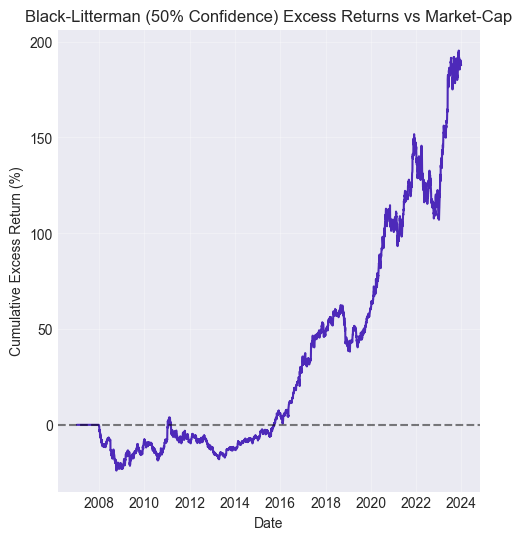

In [158]:
bl_50_name = 'BL (Confidence 50%)'
bl_50_values = all_results[bl_50_name]
market_values = all_results['Market-Cap Weighted']

# Calculate excess returns
excess_returns = (bl_50_values.pct_change() - market_values.pct_change()).dropna()
cumulative_excess = (1 + excess_returns).cumprod() - 1

# Plot excess returns
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cumulative_excess.index, cumulative_excess * 100, color = '#4d29b9')
plt.title('Black-Litterman (50% Confidence) Excess Returns vs Market-Cap')
plt.xlabel('Date')
plt.ylabel('Cumulative Excess Return (%)')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.show()

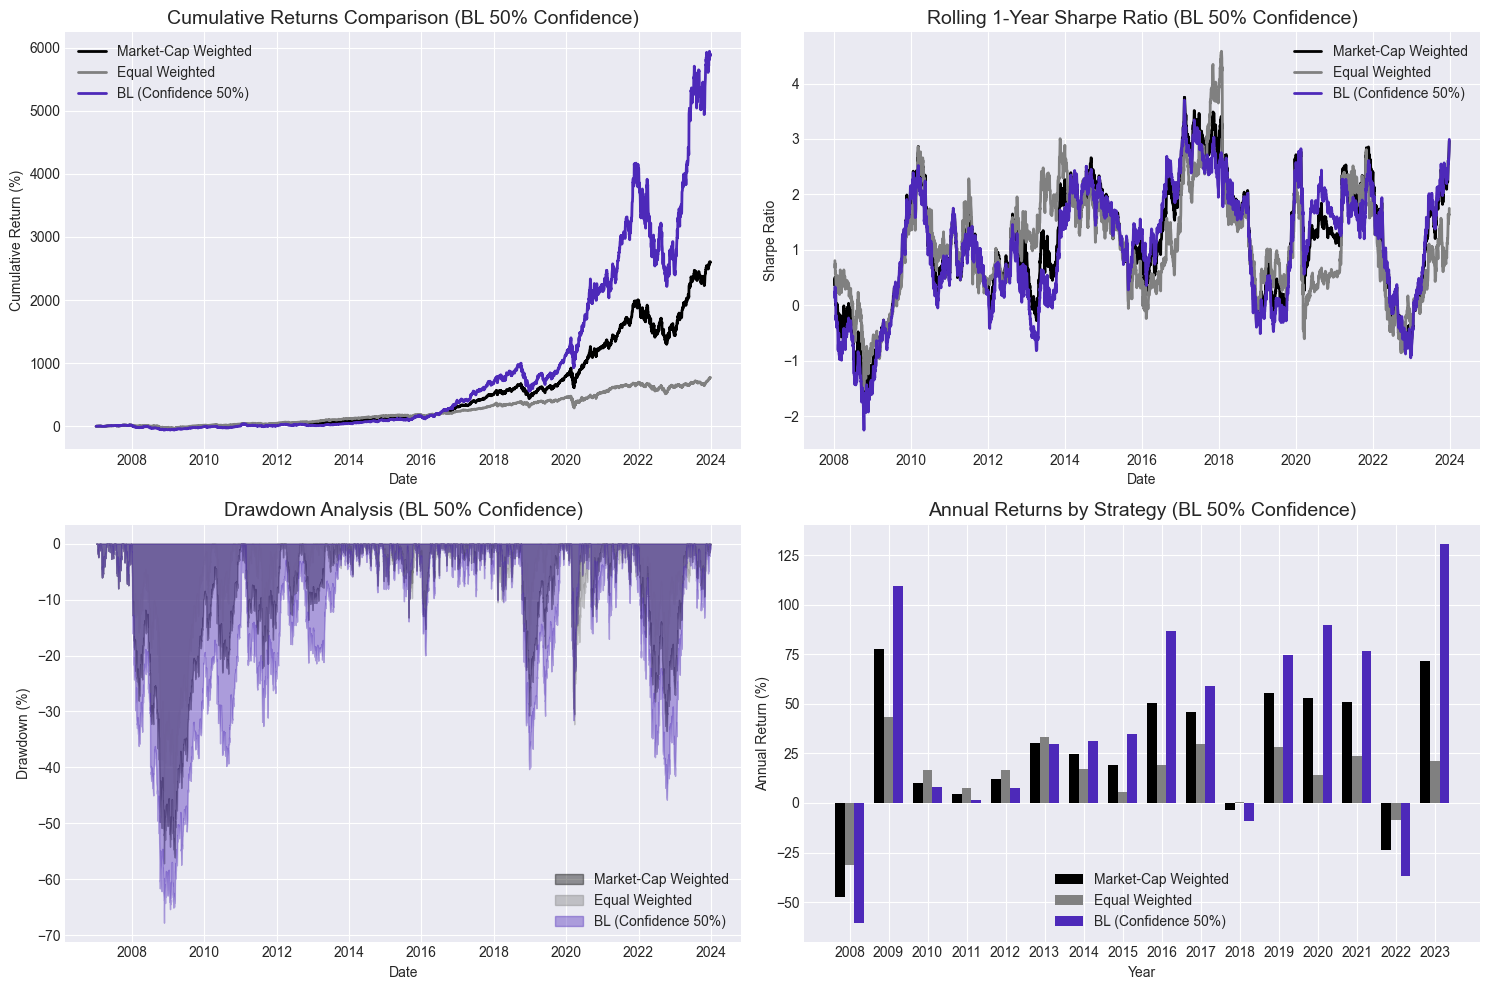


Performance Summary - Black-Litterman 75% Confidence vs Benchmarks:
           Strategy Total Return Annual Return Annual Vol Sharpe Ratio Max Drawdown Win Rate
Market-Cap Weighted      2603.1%         22.5%      24.6%        0.751       -57.2%    55.3%
     Equal Weighted       771.2%         14.7%      19.7%        0.544       -47.0%    55.4%
BL (Confidence 50%)      5890.9%         29.2%      31.8%        0.792       -67.8%    54.8%

Black-Litterman (50%) vs Market-Cap Performance:
Average daily excess return: 6.73% annualized
Information Ratio: 0.673
Win rate (days BL outperforms): 48.9%


In [168]:
# Filter to only show 75% confidence BL and benchmarks
strategies_to_plot = ['Market-Cap Weighted', 'Equal Weighted', 'BL (Confidence 50%)']

# Create color scheme
strategy_colors = {
    'Market-Cap Weighted': 'black',  # Red
    'Equal Weighted': 'grey',       # Gray
    'BL (Confidence 50%)': '#4d29b9'   # Purple
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Cumulative Returns
ax1 = axes[0, 0]
for strategy in strategies_to_plot:
    if strategy in backtest.portfolio_values:
        returns = (backtest.portfolio_values[strategy] / 
                  backtest.portfolio_values[strategy].iloc[0] - 1) * 100
        ax1.plot(returns, label=strategy, linewidth=2, 
                color=strategy_colors.get(strategy, 'blue'))
ax1.set_title('Cumulative Returns Comparison (BL 50% Confidence)', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return (%)')
ax1.legend()
ax1.grid(True)

# 2. Rolling Sharpe Ratio
ax2 = axes[0, 1]
window = 252  # 1-year rolling
for strategy in strategies_to_plot:
    if strategy in backtest.portfolio_values:
        daily_returns = backtest.portfolio_values[strategy].pct_change()
        rolling_sharpe = (daily_returns.rolling(window).mean() / 
                         daily_returns.rolling(window).std() * np.sqrt(252))
        ax2.plot(rolling_sharpe, label=strategy, linewidth=2,
                color=strategy_colors.get(strategy, 'blue'))
ax2.set_title('Rolling 1-Year Sharpe Ratio (BL 50% Confidence)', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Sharpe Ratio')
ax2.legend()
ax2.grid(True)

# 3. Drawdown Analysis
ax3 = axes[1, 0]
for strategy in strategies_to_plot:
    if strategy in backtest.portfolio_values:
        # Calculate drawdown
        cum_returns = backtest.portfolio_values[strategy]
        running_max = cum_returns.expanding().max()
        drawdown = (cum_returns - running_max) / running_max * 100
        ax3.fill_between(drawdown.index, drawdown, 0, alpha=0.4, 
                        label=strategy, color=strategy_colors.get(strategy, 'blue'))
ax3.set_title('Drawdown Analysis (BL 50% Confidence)', fontsize=14)
ax3.set_xlabel('Date')
ax3.set_ylabel('Drawdown (%)')
ax3.legend()
ax3.grid(True)

# 4. Annual Returns Bar Chart
ax4 = axes[1, 1]
annual_returns = {}
for strategy in strategies_to_plot:
    if strategy in backtest.portfolio_values:
        values = backtest.portfolio_values[strategy]
        annual = values.resample('Y').last().pct_change() * 100
        annual_returns[strategy] = annual.dropna()

# Create DataFrame for grouped bar chart
if annual_returns:
    annual_df = pd.DataFrame(annual_returns)
    annual_df.index = annual_df.index.year  # Convert to just years
    
    # Create custom bar chart with our colors
    x = np.arange(len(annual_df))
    width = 0.25
    
    for i, strategy in enumerate(strategies_to_plot):
        if strategy in annual_df.columns:
            ax4.bar(x + i*width, annual_df[strategy], width, 
                   label=strategy, color=strategy_colors.get(strategy, 'blue'))
    
    ax4.set_xlabel('Year')
    ax4.set_ylabel('Annual Return (%)')
    ax4.set_title('Annual Returns by Strategy (BL 50% Confidence)', fontsize=14)
    ax4.set_xticks(x + width)
    ax4.set_xticklabels(annual_df.index)
    ax4.legend()
    ax4.grid(True, axis='y')

plt.tight_layout()
plt.show()

# %% Cell: Performance Summary for 75% Confidence
print("\nPerformance Summary - Black-Litterman 75% Confidence vs Benchmarks:")
print("="*70)

summary_data = []
for strategy in strategies_to_plot:
    if strategy in backtest.portfolio_values:
        portfolio_values = backtest.portfolio_values[strategy]
        daily_returns = portfolio_values.pct_change().dropna()
        
        # Calculate metrics
        total_return = (portfolio_values.iloc[-1] / portfolio_values.iloc[0] - 1) * 100
        annual_return = daily_returns.mean() * 252 * 100
        annual_vol = daily_returns.std() * np.sqrt(252) * 100
        sharpe_ratio = (annual_return - 4) / annual_vol  # 4% risk-free rate
        
        # Calculate max drawdown
        cum_returns = portfolio_values
        running_max = cum_returns.expanding().max()
        drawdown = (cum_returns - running_max) / running_max
        max_drawdown = drawdown.min() * 100
        
        # Calculate win rate
        win_rate = (daily_returns > 0).mean() * 100
        
        summary_data.append({
            'Strategy': strategy,
            'Total Return': f"{total_return:.1f}%",
            'Annual Return': f"{annual_return:.1f}%",
            'Annual Vol': f"{annual_vol:.1f}%",
            'Sharpe Ratio': f"{sharpe_ratio:.3f}",
            'Max Drawdown': f"{max_drawdown:.1f}%",
            'Win Rate': f"{win_rate:.1f}%"
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Calculate outperformance
if 'BL (Confidence 50%)' in backtest.portfolio_values and 'Market-Cap Weighted' in backtest.portfolio_values:
    bl_returns = backtest.portfolio_values['BL (Confidence 50%)'].pct_change()
    market_returns = backtest.portfolio_values['Market-Cap Weighted'].pct_change()
    excess_returns = bl_returns - market_returns
    
    print(f"\nBlack-Litterman (50%) vs Market-Cap Performance:")
    print(f"Average daily excess return: {excess_returns.mean()*252*100:.2f}% annualized")
    print(f"Information Ratio: {(excess_returns.mean() / excess_returns.std() * np.sqrt(252)):.3f}")
    print(f"Win rate (days BL outperforms): {(excess_returns > 0).mean()*100:.1f}%")

In [176]:
from scipy import stats

# Check if both strategies exist
bl_50_name = 'BL (Confidence 50%)'
market_name = 'Market-Cap Weighted'

if bl_50_name in backtest.portfolio_values and market_name in backtest.portfolio_values:
    # Get daily returns
    bl_returns = backtest.portfolio_values[bl_50_name].pct_change().dropna()
    market_returns = backtest.portfolio_values[market_name].pct_change().dropna()
    
    # Calculate excess returns
    excess_returns = bl_returns - market_returns
    
    # T-test for mean excess return
    t_stat, p_value = stats.ttest_1samp(excess_returns, 0)
    
    print("\n" + "="*60)
    print("STATISTICAL SIGNIFICANCE TEST - BL 50% Confidence")
    print("="*60)
    print(f"H0: Black-Litterman (50% conf) returns = Market-Cap returns")
    print(f"Mean excess return: {excess_returns.mean()*252*100:.2f}% annualized")
    print(f"T-statistic: {t_stat:.3f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("Result: Black-Litterman (50% conf) significantly outperforms (p < 0.05)")
    else:
        print("Result: No significant difference (p >= 0.05)")
    
    # Information Ratio
    info_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)
    print(f"\nInformation Ratio: {info_ratio:.3f}")
    
    # Additional statistics
    print(f"\nAdditional Statistics:")
    print(f"Daily excess return volatility: {excess_returns.std()*100:.3f}%")
    print(f"Annualized excess return volatility: {excess_returns.std()*np.sqrt(252)*100:.2f}%")
    print(f"Win rate (days BL outperforms): {(excess_returns > 0).mean()*100:.1f}%")
    print(f"Average win: {excess_returns[excess_returns > 0].mean()*100:.3f}%")
    print(f"Average loss: {excess_returns[excess_returns < 0].mean()*100:.3f}%")
    print(f"Win/Loss ratio: {abs(excess_returns[excess_returns > 0].mean() / excess_returns[excess_returns < 0].mean()):.2f}")
    
    # Confidence interval for mean excess return
    conf_level = 0.95
    df = len(excess_returns) - 1
    se = excess_returns.std() / np.sqrt(len(excess_returns))
    margin = stats.t.ppf((1 + conf_level) / 2, df) * se
    ci_lower = (excess_returns.mean() - margin) * 252 * 100
    ci_upper = (excess_returns.mean() + margin) * 252 * 100
    
    print(f"\n95% Confidence Interval for annualized excess return: [{ci_lower:.2f}%, {ci_upper:.2f}%]")
    
else:
    print(f"Error: Could not find one or both strategies:")
    print(f"  - {bl_50_name}: {'Found' if bl_50_name in backtest.portfolio_values else 'Not found'}")
    print(f"  - {market_name}: {'Found' if market_name in backtest.portfolio_values else 'Not found'}")
    print("\nAvailable strategies:", list(backtest.portfolio_values.keys()))



STATISTICAL SIGNIFICANCE TEST - BL 50% Confidence
H0: Black-Litterman (50% conf) returns = Market-Cap returns
Mean excess return: 6.73% annualized
T-statistic: 2.774
P-value: 0.0056
Result: Black-Litterman (50% conf) significantly outperforms (p < 0.05)

Information Ratio: 0.673

Additional Statistics:
Daily excess return volatility: 0.629%
Annualized excess return volatility: 9.99%
Win rate (days BL outperforms): 48.9%
Average win: 0.466%
Average loss: -0.445%
Win/Loss ratio: 1.05

95% Confidence Interval for annualized excess return: [1.97%, 11.48%]


In [177]:
print("\n" + "="*60)
print("STATISTICAL COMPARISON - ALL CONFIDENCE LEVELS")
print("="*60)

confidence_levels = ['25%', '50%', '75%', '100%']
statistical_results = []

for conf in confidence_levels:
    strategy_name = f'BL (Confidence {conf})'
    
    if strategy_name in backtest.portfolio_values and market_name in backtest.portfolio_values:
        # Get returns
        bl_returns = backtest.portfolio_values[strategy_name].pct_change().dropna()
        market_returns = backtest.portfolio_values[market_name].pct_change().dropna()
        excess_returns = bl_returns - market_returns
        
        # Calculate statistics
        t_stat, p_value = stats.ttest_1samp(excess_returns, 0)
        info_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)
        
        statistical_results.append({
            'Confidence': conf,
            'Mean Excess Return': f"{excess_returns.mean()*252*100:.2f}%",
            'T-Statistic': f"{t_stat:.3f}",
            'P-Value': f"{p_value:.4f}",
            'Significant': 'Yes' if p_value < 0.05 else 'No',
            'Info Ratio': f"{info_ratio:.3f}"
        })

if statistical_results:
    stats_df = pd.DataFrame(statistical_results)
    print(stats_df.to_string(index=False))
    
    print("\nKey Insights:")
    print(f"- Confidence levels with significant outperformance: " + 
          ", ".join([r['Confidence'] for r in statistical_results if r['Significant'] == 'Yes']))
    
    # Find optimal confidence based on Information Ratio
    info_ratios = [float(r['Info Ratio']) for r in statistical_results]
    best_conf_idx = info_ratios.index(max(info_ratios))
    print(f"- Best Information Ratio: {confidence_levels[best_conf_idx]} confidence")



STATISTICAL COMPARISON - ALL CONFIDENCE LEVELS
Confidence Mean Excess Return T-Statistic P-Value Significant Info Ratio
       25%              6.15%       2.530  0.0114         Yes      0.614
       50%              6.73%       2.774  0.0056         Yes      0.673
       75%              5.44%       2.797  0.0052         Yes      0.679
      100%              1.94%       1.277  0.2015          No      0.310

Key Insights:
- Confidence levels with significant outperformance: 25%, 50%, 75%
- Best Information Ratio: 75% confidence


Number of rebalancing periods: 48

Top 15 Holdings by Average Weight:
NVDA: 43.30%
AAPL: 28.50%
MSFT: 24.63%
CRM: 2.71%
VZ: 0.61%
INTC: 0.13%
GS: 0.11%
KO: 0.00%
WBA: 0.00%
UNH: 0.00%
TRV: 0.00%
PG: 0.00%
NKE: 0.00%
MRK: 0.00%
MMM: 0.00%


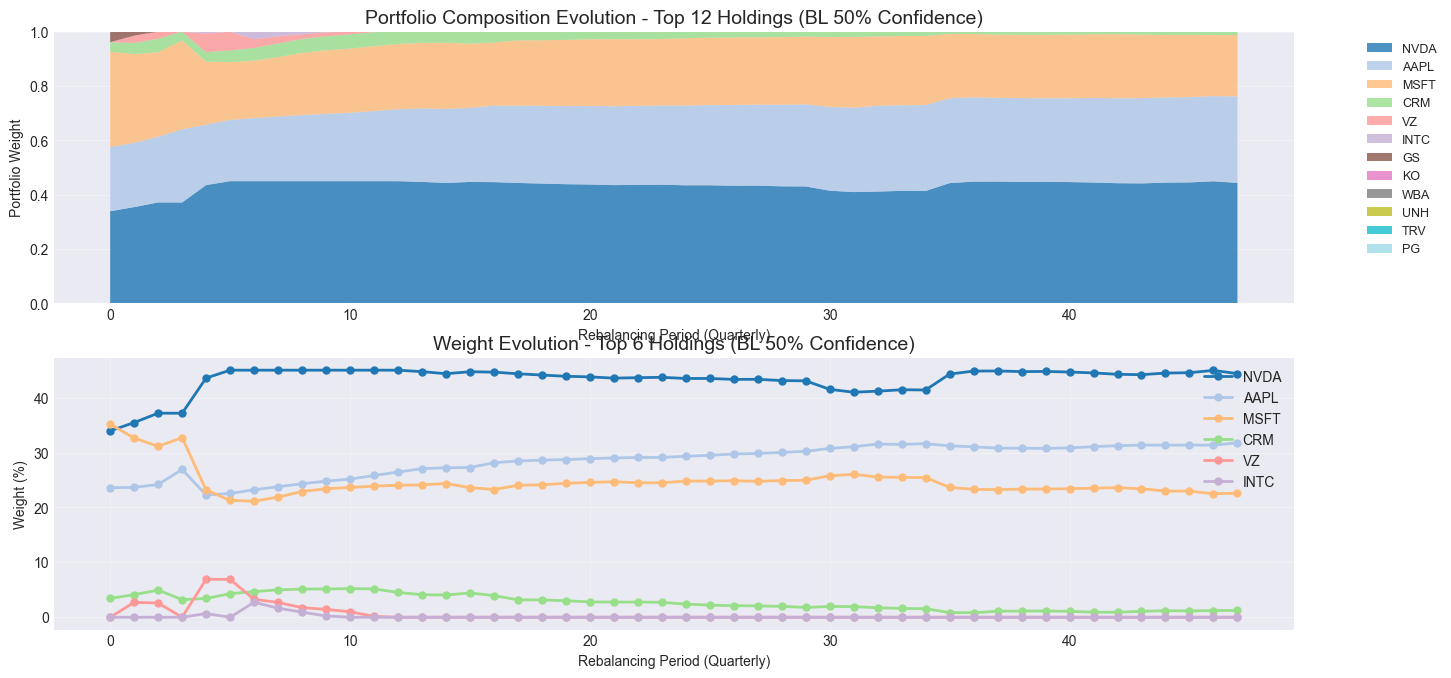

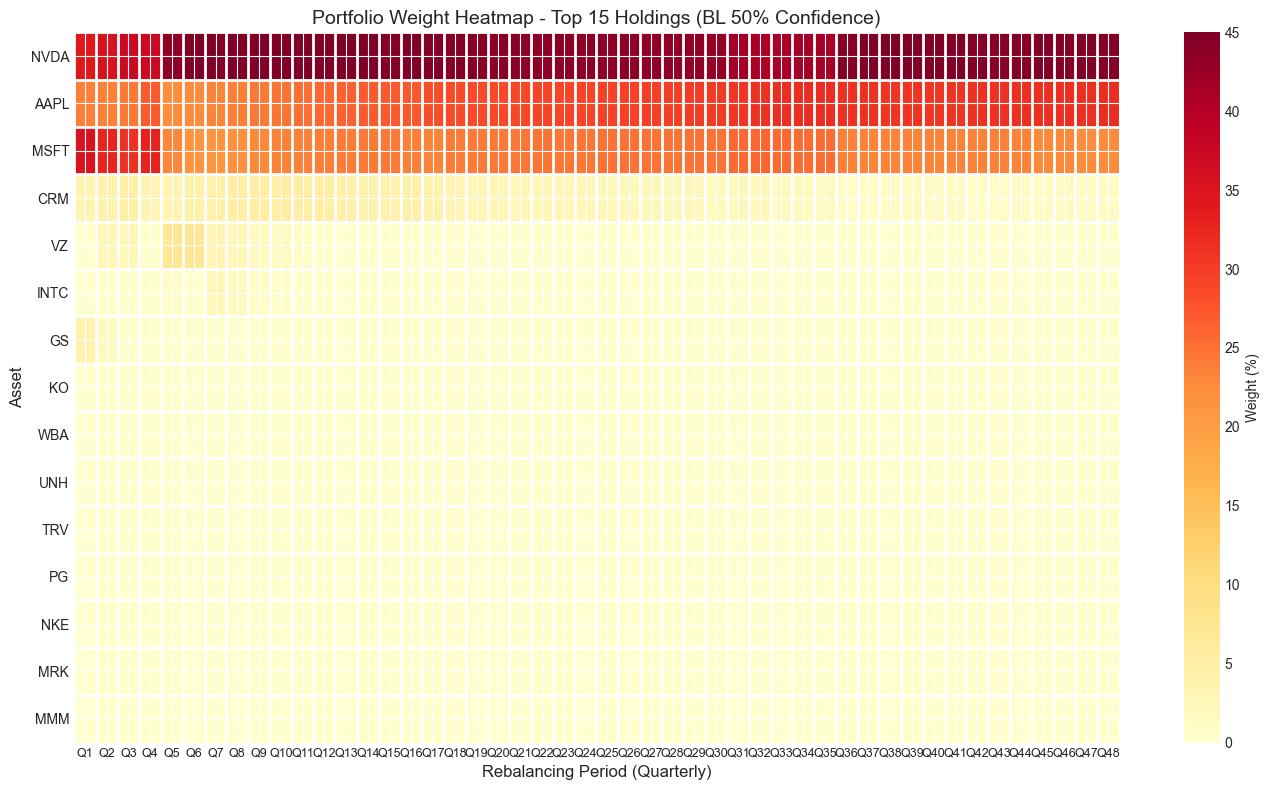


Weight Analysis: Assets with Views vs Without Views

Assets with views (8):
  AAPL: 28.50%
  AXP: 0.00%
  CVX: 0.00%
  INTC: 0.13%
  JPM: 0.00%
  MSFT: 24.63%
  NVDA: 43.30%
  VZ: 0.61%

Average weight for assets WITH views: 12.15%
Average weight for assets WITHOUT views: 0.13%
Ratio: 90.34x

Weight Stability Analysis (Standard Deviation of Weights)


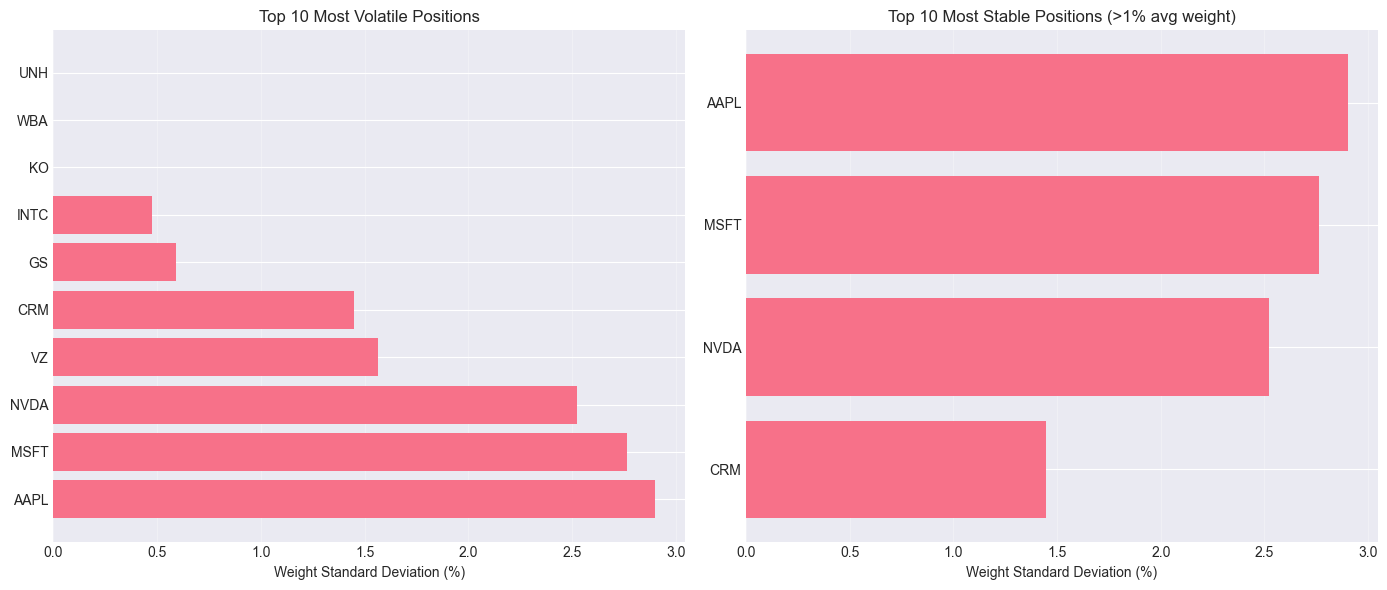

In [ ]:
strategy_name = 'BL (Confidence 50%)'

if strategy_name in backtest.weights_history and backtest.weights_history[strategy_name]:
    # Convert weights history to DataFrame
    weights_df = pd.DataFrame(backtest.weights_history[strategy_name])
    
    # Calculate average weights to identify top holdings
    avg_weights = weights_df.mean().sort_values(ascending=False)
    
    print(f"Number of rebalancing periods: {len(weights_df)}")
    print(f"\nTop 15 Holdings by Average Weight:")
    for ticker, weight in avg_weights.head(15).items():
        print(f"{ticker}: {weight:.2%}")
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Stacked Area Chart - Top 12 Holdings
    ax1 = plt.subplot(3, 1, 1)
    top_n = 12
    top_holdings = avg_weights.head(top_n).index
    
    # Prepare data for stacked area chart
    weights_subset = weights_df[top_holdings].T
    weights_subset.columns = range(len(weights_subset.columns))  # Numeric index for x-axis
    
    # Create color palette
    colors = plt.cm.tab20(np.linspace(0, 1, top_n))
    
    # Create stacked area plot
    ax1.stackplot(weights_subset.columns, 
                  [weights_subset.loc[ticker] for ticker in top_holdings],
                  labels=top_holdings,
                  colors=colors,
                  alpha=0.8)
    
    ax1.set_title(f'Portfolio Composition Evolution - Top {top_n} Holdings (BL 50% Confidence)', fontsize=14)
    ax1.set_xlabel('Rebalancing Period (Quarterly)')
    ax1.set_ylabel('Portfolio Weight')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # 2. Line Chart - Top 6 Individual Holdings
    ax2 = plt.subplot(3, 1, 2)
    top_6 = avg_weights.head(6).index
    
    for i, ticker in enumerate(top_6):
        ax2.plot(weights_df[ticker].values * 100, 
                marker='o', 
                label=ticker, 
                linewidth=2,
                markersize=5,
                color=colors[i])
    
    ax2.set_title('Weight Evolution - Top 6 Holdings (BL 50% Confidence)', fontsize=14)
    ax2.set_xlabel('Rebalancing Period (Quarterly)')
    ax2.set_ylabel('Weight (%)')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # 4. Heatmap of Weight Evolution
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Select top 15 holdings for heatmap
    top_15 = avg_weights.head(15).index
    heatmap_data = weights_df[top_15].T * 100  # Convert to percentage
    
    # Create heatmap
    im = ax.imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto')
    
    # Set ticks
    ax.set_xticks(np.arange(len(weights_df)))
    ax.set_yticks(np.arange(len(top_15)))
    ax.set_xticklabels([f'Q{i+1}' for i in range(len(weights_df))], fontsize=9)
    ax.set_yticklabels(top_15, fontsize=10)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Weight (%)', fontsize=10)
    
    # Add title
    ax.set_title('Portfolio Weight Heatmap - Top 15 Holdings (BL 50% Confidence)', fontsize=14)
    ax.set_xlabel('Rebalancing Period (Quarterly)', fontsize=12)
    ax.set_ylabel('Asset', fontsize=12)
    
    # Add grid
    ax.set_xticks(np.arange(len(weights_df))-.5, minor=True)
    ax.set_yticks(np.arange(len(top_15))-.5, minor=True)
    ax.grid(which="minor", color="white", linestyle='-', linewidth=2)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Analysis of Assets with Views vs Without
    print("\n" + "="*60)
    print("Weight Analysis: Assets with Views vs Without Views")
    print("="*60)
    
    # Get assets that have views (from your enhanced views function)
    P_views, Q_views, conf_views, desc_views = generate_enhanced_bl_views(confidence=0.75)
    
    # Extract assets mentioned in views
    assets_with_views = set()
    for i in range(P_views.shape[0]):
        assets_idx = np.where(P_views[i] != 0)[0]
        for idx in assets_idx:
            assets_with_views.add(prices.columns[idx])
    
    # Compare average weights
    weights_with_views = []
    weights_without_views = []
    
    for ticker in weights_df.columns:
        avg_weight = avg_weights[ticker]
        if ticker in assets_with_views:
            weights_with_views.append(avg_weight)
        else:
            weights_without_views.append(avg_weight)
    
    print(f"\nAssets with views ({len(assets_with_views)}):")
    for asset in sorted(assets_with_views):
        if asset in avg_weights.index:
            print(f"  {asset}: {avg_weights[asset]:.2%}")
    
    print(f"\nAverage weight for assets WITH views: {np.mean(weights_with_views):.2%}")
    print(f"Average weight for assets WITHOUT views: {np.mean(weights_without_views):.2%}")
    print(f"Ratio: {np.mean(weights_with_views) / np.mean(weights_without_views):.2f}x")
    
    # 6. Weight Stability Analysis
    print("\n" + "="*60)
    print("Weight Stability Analysis (Standard Deviation of Weights)")
    print("="*60)
    
    weight_volatility = weights_df.std().sort_values(ascending=False)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Top 10 most volatile
    ax1.barh(weight_volatility.head(10).index, weight_volatility.head(10).values * 100)
    ax1.set_xlabel('Weight Standard Deviation (%)')
    ax1.set_title('Top 10 Most Volatile Positions')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Top 10 most stable (excluding near-zero weights)
    stable_weights = weight_volatility[avg_weights > 0.01].sort_values().head(10)
    ax2.barh(stable_weights.index, stable_weights.values * 100)
    ax2.set_xlabel('Weight Standard Deviation (%)')
    ax2.set_title('Top 10 Most Stable Positions (>1% avg weight)')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
else:
    print(f"No weight history found for {strategy_name}")
    print("Make sure the backtest has been run with this strategy name.")

In [43]:
results_df = pd.DataFrame(backtest.portfolio_values)
results_df.to_csv('backtest_results.csv')

# Save final weights
final_weights = {}
for strategy in strategies:
    final_weights[strategy] = strategies[strategy](prices)

final_weights_df = pd.DataFrame(final_weights)
final_weights_df.to_csv('final_portfolio_weights.csv')

print("\nResults saved to:")
print("- backtest_results.csv")
print("- final_portfolio_weights.csv")


Results saved to:
- backtest_results.csv
- final_portfolio_weights.csv
